In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.manifold import TSNE

In [2]:
import os

audio_folder = '/home/badr/explore_wav2vec/spoken_digit/speech_data'
audio_files = []

for file in os.listdir(audio_folder):
    if file.endswith('.wav') or file.endswith('.mp3'):
        audio_files.append(os.path.join(audio_folder, file))



In [3]:
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

In [4]:
import librosa

audio_data = {}
metadata = {}

for file in audio_files:
    file_name = os.path.basename(file)
    label, speaker_id, sample_number = file_name.split('_')
    
    # Read audio file
    audio, sr = librosa.load(file, sr=8000)
    
    # Store audio data
    audio_data[file_name] = audio
    
    # Store metadata
    metadata[file_name] = {
        'label': label,
        'speaker_id': speaker_id,
        'sample_number': sample_number.split('.')[0]
    }


In [5]:
metadata[audio_files[0].split('/')[-1]]

{'label': '4', 'speaker_id': 'nicolas', 'sample_number': '28'}

In [14]:
resampled_samples = defaultdict()

for i, sample_ID in enumerate(metadata):


    # Get audio data
    file_name = audio_folder + '/' + sample_ID

    waveform, sample_rate = torchaudio.load(file_name)
    
    resampler = torchaudio.transforms.Resample(8_000, 16_000) 

    waveform = resampler(waveform)

    resampled_samples[sample_ID] = waveform

    print(f"{(100*i)/len(audio_files):.2f}%", end='\r')

In [7]:
# Load pre-trained model and processor
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")


/home/badr/anaconda3/lib/python3.11/site-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'lm_head.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
processed_samples['4_nicolas_1.wav']

tensor([[-0.0077, -0.0034, -0.0002,  ..., -0.0055, -0.0001,  0.0017]])

In [15]:
layer_reprs = defaultdict()

for i, sample_ID in enumerate(resampled_samples):
    
    # Tokenize and forward pass through the model
    processed_sample = processor(
        resampled_samples[sample_ID].squeeze().numpy(), 
        return_tensors="pt", 
        sampling_rate=16000
    ).input_values

    with torch.no_grad():
        layer_reprs[sample_ID] = model(processed_sample, output_hidden_states=True).hidden_states


    print(f"{(100*i)/len(resampled_samples):.2f}%", end='\r')

In [38]:
layer_reprs['7_george_0.wav'][0].mean(dim=1).shape

torch.Size([1, 768])

In [142]:
# Get metadata in lists 
# Iterate over the layers and plot the representations
speaker_ids, labels = [], []

for sample_ID in layer_reprs:
    speaker_id = metadata[sample_ID]['speaker_id']
    label = int(metadata[sample_ID]['label'])

    speaker_ids.append(speaker_id)
    labels.append(label)

/tmp/ipykernel_7124/666930736.py:63: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


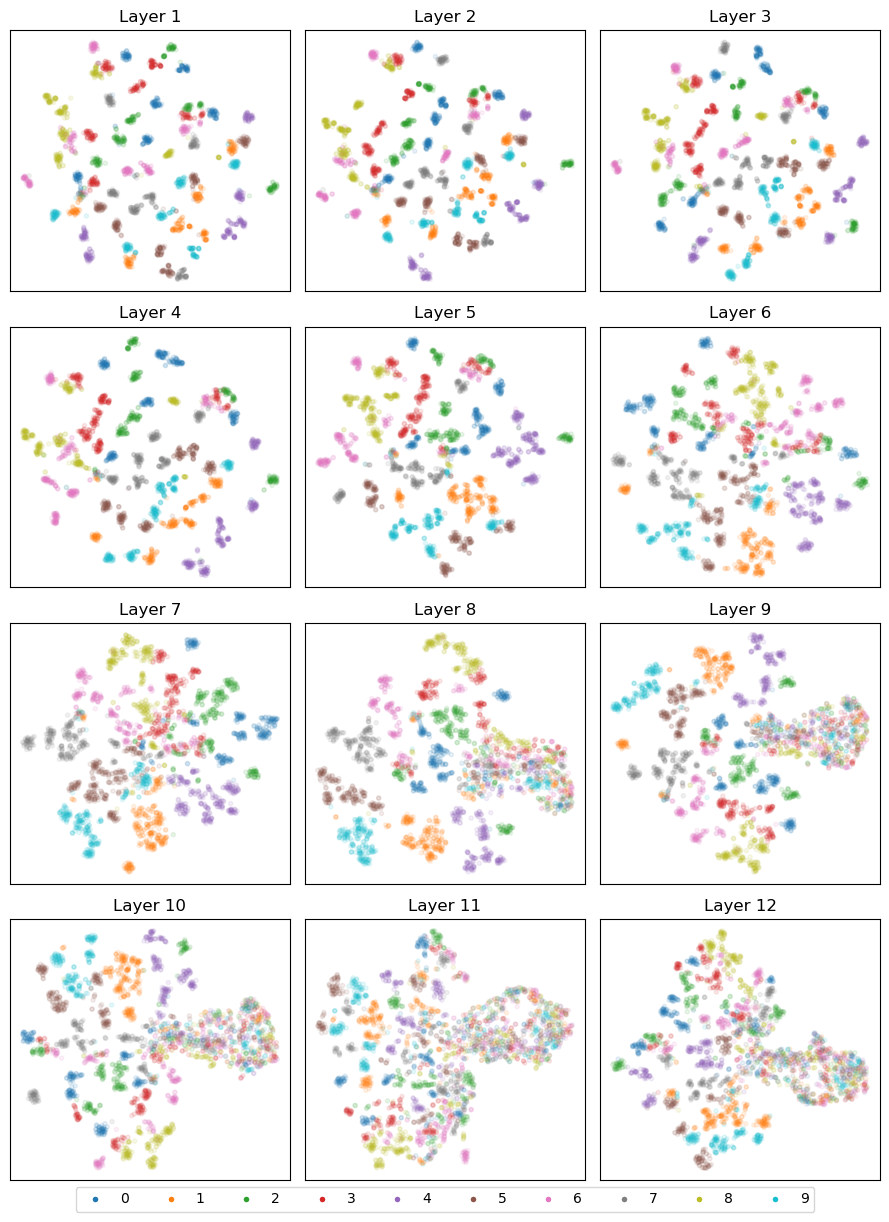

In [143]:



# Define the number of rows and columns for the subplot matrix
num_rows = 4
num_cols = 3

# Create a new figure and set the size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 12))

# Flatten the axes array
axes = axes.flatten()

# Iterate over the layers and plot the representations
for i, layer_index in enumerate(range(1, 13)):
    # Extract representations from the specified layer
    layer_representations = []
    #speaker_ids, labels = [], []
    
    for sample_ID in layer_reprs:
        layer_representations.append(layer_reprs[sample_ID][layer_index].mean(dim=1).squeeze().numpy())
        #speaker_id = metadata[sample_ID]['speaker_id']
        #label = int(metadata[sample_ID]['label'])

        #speaker_ids.append(speaker_id)
        #labels.append(label)

    # Convert the representations to a NumPy array
    layer_representations = np.array(layer_representations)

    # Perform T-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    tsne_representation = tsne.fit_transform(layer_representations)

    # Plot the representations in the current subplot
    scatter = axes[i].scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=labels, cmap='tab10', alpha=0.1, marker='.')
    axes[i].set_title(f'Layer {layer_index}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Remove any extra subplots
for j in range(len(axes)):
    if j >= len(layer_reprs):
        fig.delaxes(axes[j])



# Adjust the spacing between subplots
fig.tight_layout()

# Add legend with color labels at the bottom
legend_labels = np.unique(labels)
legend_handles = [plt.Line2D([0], [0], marker='.', color='w', markerfacecolor=scatter.get_cmap()(scatter.norm(label)), markersize=10) for label in legend_labels]

fig.legend(legend_handles, legend_labels, loc='lower center', ncol=len(legend_labels), bbox_to_anchor=(0.5, -0.02))

# Show the plot
#plt.show()

#fig.legend(legend_handles, legend_labels, loc='lower center', ncol=len(legend_labels))

# Show the plot
#plt.show()

# Adjust the spacing between subplots
fig.tight_layout()


# Show the plot
plt.show()

In [144]:
from sklearn.preprocessing import LabelEncoder

# Convert the categorical list into a list of integers
label_encoder = LabelEncoder()
speaker_ids_encoded = label_encoder.fit_transform(speaker_ids)

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U6'), dtype('float64')) -> None

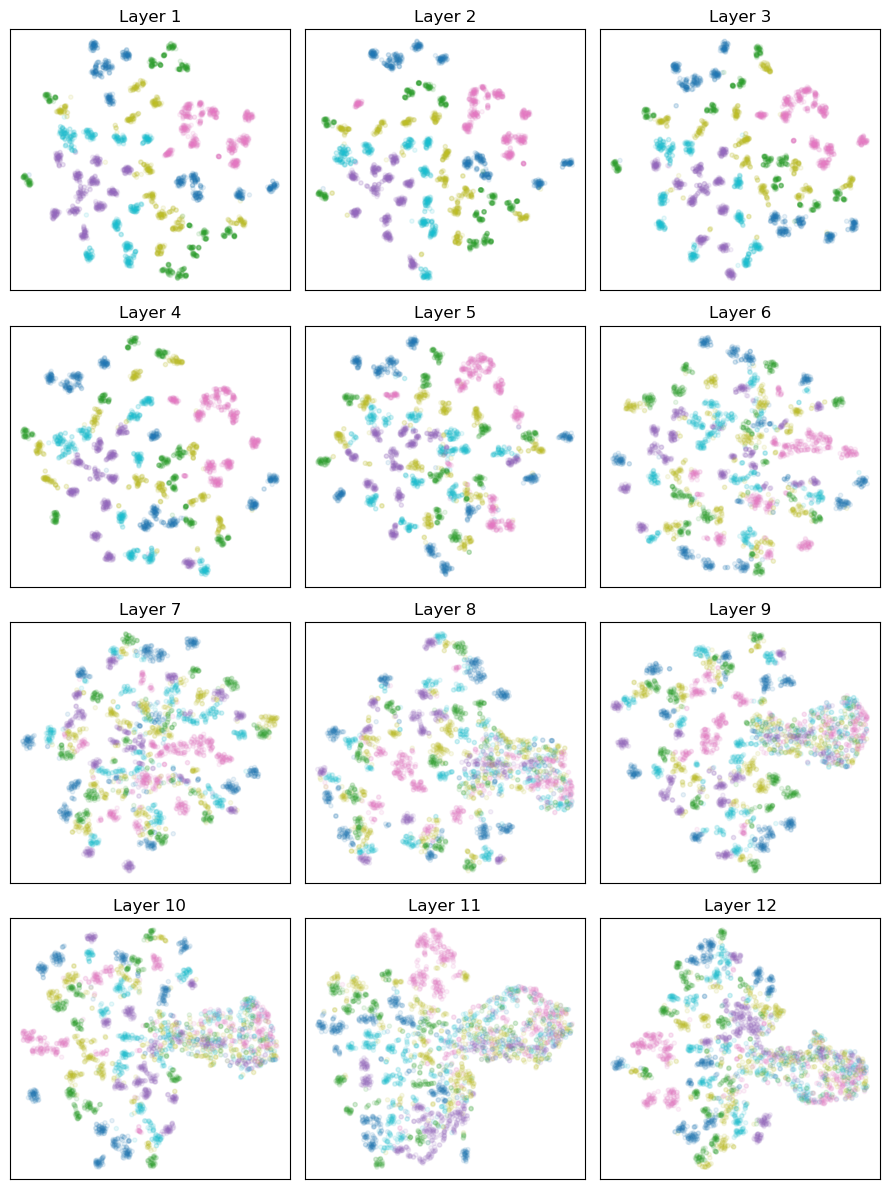

In [145]:
# Define the number of rows and columns for the subplot matrix
num_rows = 4
num_cols = 3

# Create a new figure and set the size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 12))

# Flatten the axes array
axes = axes.flatten()

# Iterate over the layers and plot the representations
for i, layer_index in enumerate(range(1, 13)):
    # Extract representations from the specified layer
    layer_representations = []
    
    for sample_ID in layer_reprs:
        layer_representations.append(layer_reprs[sample_ID][layer_index].mean(dim=1).squeeze().numpy())

    # Convert the representations to a NumPy array
    layer_representations = np.array(layer_representations)

    # Perform T-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    tsne_representation = tsne.fit_transform(layer_representations)

    # Plot the representations in the current subplot
    scatter = axes[i].scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=speaker_ids_encoded, cmap='tab10', alpha=0.1, marker='.')
    axes[i].set_title(f'Layer {layer_index}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Remove any extra subplots
for j in range(len(axes)):
    if j >= len(layer_reprs):
        fig.delaxes(axes[j])



# Adjust the spacing between subplots
fig.tight_layout()

# Add legend with color labels at the bottom
legend_labels = set(speaker_ids)
legend_handles = [plt.Line2D([0], [0], marker='.', color='w', markerfacecolor=scatter.get_cmap()(scatter.norm(label)), markersize=10) for label in legend_labels]

fig.legend(legend_handles, legend_labels, loc='lower center', ncol=len(legend_labels), bbox_to_anchor=(0.5, -0.02))

# Show the plot
#plt.show()

#fig.legend(legend_handles, legend_labels, loc='lower center', ncol=len(legend_labels))

# Show the plot
#plt.show()

# Adjust the spacing between subplots
fig.tight_layout()


# Show the plot
plt.show()

In [147]:
legend_labels

{'george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler'}

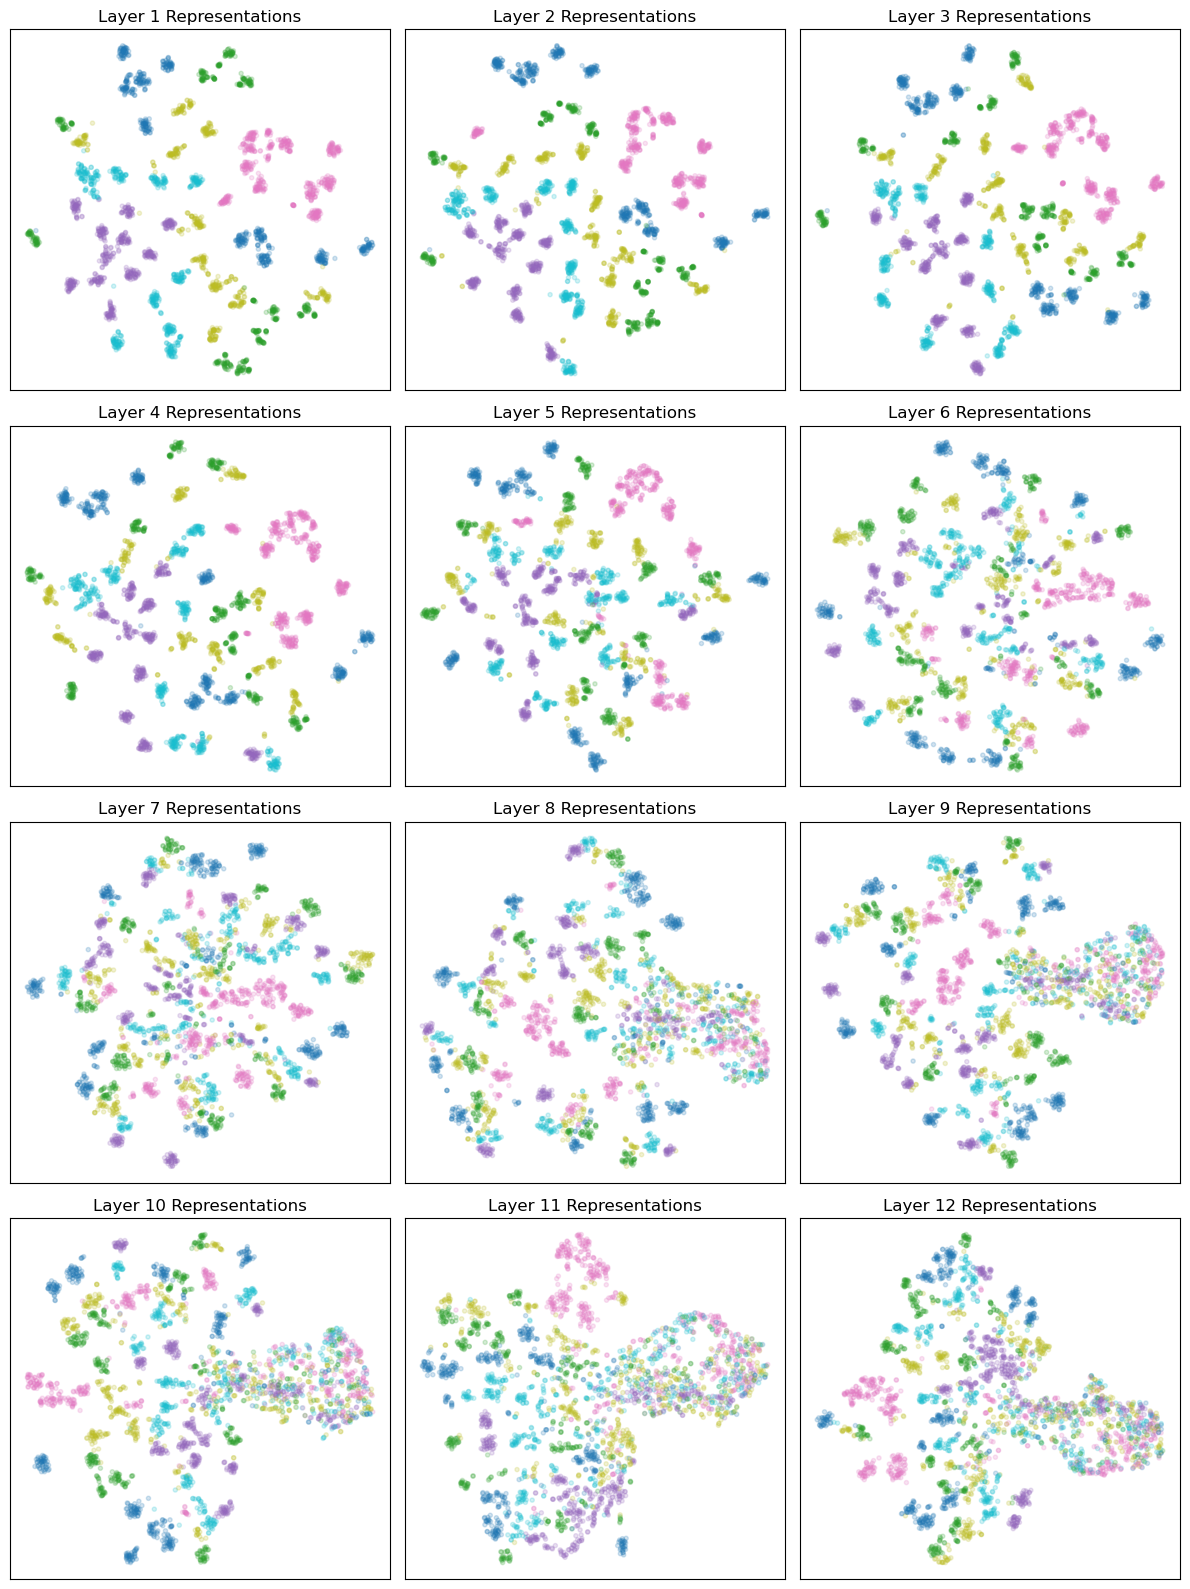

In [126]:
# Define the number of rows and columns for the subplot matrix
num_rows = 4
num_cols = 3

# Create a new figure and set the size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 16))

# Flatten the axes array
axes = axes.flatten()

# Iterate over the layers and plot the representations
for i, layer_index in enumerate(range(1, 13)):
    # Extract representations from the specified layer
    layer_representations = []
    for sample_ID in layer_reprs:
        layer_representations.append(layer_reprs[sample_ID][layer_index].mean(dim=1).squeeze().numpy())

    # Convert the representations to a NumPy array
    layer_representations = np.array(layer_representations)

    # Perform T-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    tsne_representation = tsne.fit_transform(layer_representations)

    # Plot the representations in the current subplot
    scatter = axes[i].scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=speaker_ids_encoded, cmap='tab10', alpha=0.2, marker='.')
    axes[i].set_title(f'Layer {layer_index} Representations')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Remove any extra subplots
for j in range(len(axes)):
    if j >= len(layer_reprs):
        fig.delaxes(axes[j])

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

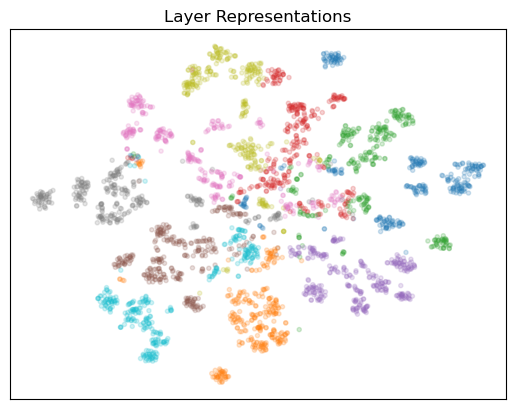

In [119]:



# Extract representations from layer 7
layer_representations = []


speaker_ids, labels = [], []
for sample_ID in layer_reprs:
    layer_representations.append(layer_reprs[sample_ID][7].mean(dim=1).squeeze().numpy())

    speaker_id = metadata[sample_ID]['speaker_id']
    label = int(metadata[sample_ID]['label'])
    
    speaker_ids.append(speaker_id)
    labels.append(label)



# Convert the representations to a NumPy array
layer_representations = np.array(layer_representations)

# Perform T-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_representation = tsne.fit_transform(layer_representations)


scatter = plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=labels, cmap='tab10', alpha=0.2, marker='.')
plt.title('Layer Representations')

plt.xticks([])
plt.yticks([])

plt.show()

In [125]:
speaker_ids_encoded

array([3, 4, 1, ..., 0, 1, 4])

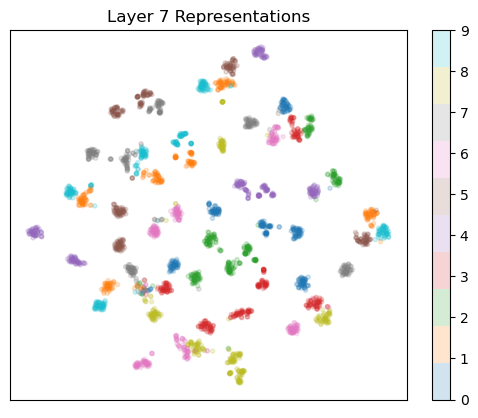

In [114]:
scatter = plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=labels, cmap='tab10', alpha=0.2, marker='.')
plt.title('Layer 7 Representations')
#plt.xlabel('Dimension 1')
#plt.ylabel('Dimension 2')

# Add legend with color labels on the side
#legend_labels = np.unique(labels)
#legend_handles = [plt.Line2D([0], [0], marker='.', color='w', markerfacecolor=colors(norm(label)), markersize=14) for label in legend_labels]
#plt.legend(legend_handles, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

# Remove ticks and labels on x-axis and y-axis
plt.xticks([])
plt.yticks([])

# Add colorbar
plt.colorbar()

plt.show()

In [11]:
# Calculate cosine similarity matrix
from sklearn.metrics.pairwise import cosine_similarity

def plot_self_similarity_matrix(intermediate_layer_outputs, layer_index=0):
    # Calculate the self-similarity matrix
    #similarity_matrix = torch.cosine_similarity(intermediate_layer_outputs[layer_index].transpose(0, 1), 
    #    intermediate_layer_outputs[layer_index].transpose(0, 1), 
    #    dim=-1
    #)

    # Convert the tensor to a NumPy array
    #similarity_matrix_np = similarity_matrix.numpy()

    print(intermediate_layer_outputs[layer_index].shape)
    similarity_matrix = cosine_similarity(intermediate_layer_outputs[layer_index][0])
    
    sim_mean = similarity_matrix.mean()

    sim_stddev = np.std(similarity_matrix)

    print(sim_mean, sim_stddev)
    similarity_matrix_adjusted = similarity_matrix - sim_mean#) #/ sim_stddev

    #similarity_matrix = similarity_matrix - sim_mean


    print(similarity_matrix_adjusted.shape, sim_mean, sim_stddev)

    # Plot the self-similarity matrix
    plt.imshow(similarity_matrix_adjusted, cmap='Blues', origin='upper', aspect='auto', vmin=0, vmax=1)
    plt.title(f'Self-Similarity Matrix (Layer {layer_index})')
    plt.xlabel('Frame Index')
    plt.ylabel('Frame Index')
    plt.colorbar(label='Cosine Similarity')
    plt.show()


torch.Size([1, 18, 768])
0.4490437 0.23096436
(18, 18) 0.4490437 0.23096436


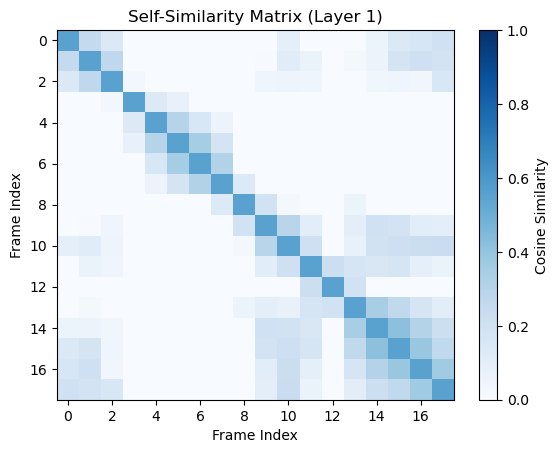

In [12]:
plot_self_similarity_matrix(layer_reprs, layer_index=1)

torch.Size([1, 18, 768])
0.84913 0.10943695
(18, 18) 0.84913 0.10943695


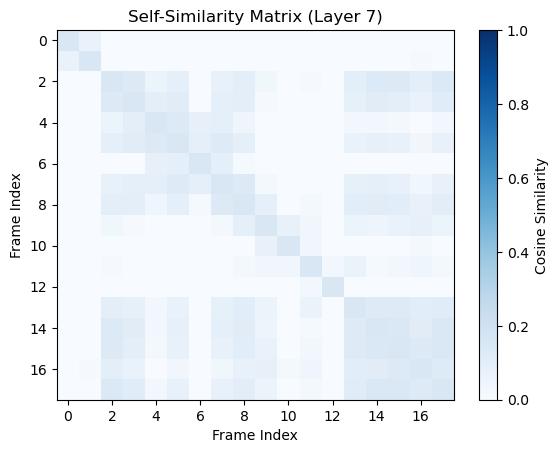

In [45]:
plot_self_similarity_matrix(layer_reprs, layer_index=7)